# **Feature Selection**

This notebook performs descriptor selection to reduce model complexity and improve generalization. It includes:

- Calculating feature importances using Random Forest across 300 resampled datasets.   
- Selecting top descriptors based on an elbow point in the ranked importance curve.

## **Step1: RF-based Feature Importances**
To identify informative molecular descriptors for classification, we applied **Random Forest (RF)**-based feature importance analysis across 300 resampled training datasets.

1. For each of the 300 resampled training datasets:
   - Train 50 Random Forest models using different random seeds.
   - Extract feature importances from each run.
   - Compute the mean importance score for each descriptor.
2. Combine the 300 mean importance vectors into a `300 × 893` matrix.
3. Save the matrix as `Feature_Importances_300dataset.csv` for use in Step 2.

These averaged importance scores capture consistent descriptor relevance across diverse resampling conditions.

### **Input and Output files:**
* Input file:
    * ./train/train_set_{dataset_number}_1016.csv (dataset_number: 1~300)
* Output file:
    * Feature_Importances_300dataset.csv

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

# Constants
n_datasets = 300  # Total number of datasets
n_runs = 50       # Number of runs per dataset
initial_seed = 42
np.random.seed(initial_seed)
random_states = np.random.randint(0, 1000, size=n_runs)

# To store mean feature importances for each dataset
all_importances = []

for dataset_number in tqdm(range(1, n_datasets + 1), desc="Processing Datasets"):
    data_path = f'./train/train_set_{dataset_number}_1016.csv'
    train_df = pd.read_csv(data_path, index_col=0)
    
    X = train_df.drop("y_true", axis=1)
    y = train_df["y_true"]
    
    # Store feature importances for n_runs in this dataset
    run_importances = np.zeros((n_runs, X.shape[1]))
    
    for run in range(n_runs):
        rf = RandomForestClassifier(n_estimators=100, random_state=random_states[run])
        rf.fit(X, y)
        run_importances[run, :] = rf.feature_importances_
    
    # Compute mean importance for the current dataset
    mean_importances = run_importances.mean(axis=0)
    all_importances.append(mean_importances)

'''
    # Optionally, compute standard deviation and coefficient of variation (CV) for each feature
    std_importances = run_importances.std(axis=0)
    cv_importances = std_importances / mean_importances
    
    stability_df = pd.DataFrame({
        'feature': X.columns,
        'mean_importance': mean_importances,
        'std_importance': std_importances,
        'CV': cv_importances
    })
    
    stability_list.append(stability_df)

# To check the stability of a single dataset (e.g., Dataset_1):
print("Example: Stability metrics of Dataset_1")
print(stability_list[0].sort_values('CV', ascending=True).head(10))
'''

# If you want to calculate overall stability across all datasets,
# you can compute mean CV per feature as follows:
importances_df = pd.DataFrame(
    all_importances,
    index=[f'Dataset_{i}' for i in range(1, n_datasets + 1)],
    columns=X.columns
)

# # To calculate overall mean and std across all datasets:
# mean_imp_overall = importances_df.mean(axis=0)
# std_imp_overall = importances_df.std(axis=0)
# cv_overall = std_imp_overall / mean_imp_overall

# overall_stability = pd.DataFrame({
#     'mean_importance': mean_imp_overall,
#     'std_importance': std_imp_overall,
#     'CV': cv_overall
# }).sort_values('CV', ascending=True)

# print("\nOverall stability metrics across all datasets (sorted by lowest CV):")
# print(overall_stability.head(10))

# Save the final DataFrame
importances_df.to_csv("Feature_Importances_300dataset.csv", index=True)

Processing Datasets: 100%|██████████████████████████████████████████████████████████████████████████| 300/300 [6:20:01<00:00, 76.00s/it]


예시: Dataset_1의 안정성 평가 결과
     feature  mean_importance  std_importance        CV
183   ATSC6s         0.001554        0.000290  0.186462
225   MATS8v         0.001376        0.000280  0.203145
149   ATSC8v         0.001631        0.000337  0.206829
129   ATSC6c         0.001539        0.000325  0.211426
216  AATSC4s         0.001620        0.000360  0.222526
258   GATS4s         0.001729        0.000390  0.225344
303  VE3_Dze         0.001720        0.000389  0.226130
337  VE3_Dzs         0.002025        0.000460  0.227339
231   GATS2c         0.002165        0.000503  0.232248
180   ATSC3s         0.001546        0.000362  0.234211


## **Step2: Automated Elbow Point Detection with KneeLocator**
To automate the feature selection cutoff, we applied the **KneeLocator** algorithm to the ranked median feature importance curve.


1. Load `Feature_Importances_300dataset.csv` and compute the **median importance** of each feature across all 300 datasets.
2. Sort the descriptors by median importance in descending order.
3. Apply **KneeLocator** to identify:
   - **Elbow Point 1**: the point where importance begins to drop sharply.
   - **Elbow Point 2** (optional): a second inflection in the lower-importance region.
4. Select:
   - Features from rank 1 to `elbow_1` as the **core important descriptors**.
   - Features from `elbow_1` to `elbow_2` as **moderately important descriptors** (optional).
5. Visualize the ranked importance curve with both elbow points and the global mean as reference.
    * **Fig. 2** Descriptor ranking and elbow-point determination for feature selection.

### **Input and Output files:**
* Input file:
    * ./Feature_Importances_300dataset.csv
* Figure Output file:
    * ./Feature Importances with Elbow Point.jpg 

In [4]:
### 1st and 2nd Elbow point detection ###
from kneed import KneeLocator
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the feature importance matrix from 300 datasets (shape: 300 × 893)
importances_df = pd.read_csv("Feature_Importances_300dataset.csv", index_col=0)

# Compute the median importance of each feature across all datasets (axis=0 → column-wise)
median_importances = importances_df.median(axis=0)

# Sort features by median importance in descending order
median_importances_sorted = median_importances.sort_values(ascending=False)

# Compute the global mean of the 893 median feature importance values
mean_893_importance = median_importances.mean()

# Feature index for plotting
feature_indices = np.arange(1, len(median_importances_sorted) + 1)

# ---------------------------
# 1) First Elbow Point Detection
# ---------------------------
kneedle_1 = KneeLocator(
    feature_indices,
    median_importances_sorted.values,
    curve='convex',         # Assumes the curve is convex (i.e., steep drop-off)
    direction='decreasing'  # Feature importance drops from high to low
)
elbow_1 = kneedle_1.knee
print("First elbow point:", elbow_1)

# ---------------------------
# 2) Second Elbow Point Detection
# ---------------------------
# Detect second elbow only if the first elbow is valid
elbow_2 = None
if elbow_1 is not None:
    x2 = feature_indices[elbow_1:]
    y2 = median_importances_sorted.values[elbow_1:]
    if len(y2) > 10:  # Avoid instability from too few points
        kneedle_2 = KneeLocator(x2, y2, curve='convex', direction='decreasing')
        elbow_2 = kneedle_2.knee
        print(f"Second elbow point: {elbow_2}")

# ---------------------------
# Extract feature sets based on elbow points
# ---------------------------
if elbow_1 is not None:
    selected_features_1 = median_importances_sorted.index[:elbow_1]
    print(f"Number of features selected by Elbow 1: {len(selected_features_1)}")

if elbow_2 is not None:
    selected_features_2 = median_importances_sorted.index[elbow_1:elbow_2]
    print(f"Number of features in Elbow 2 range: {len(selected_features_2)}")


First elbow point: 51
Second elbow point: 79
Number of features selected by Elbow 1: 51
Number of features in Elbow 2 range: 28


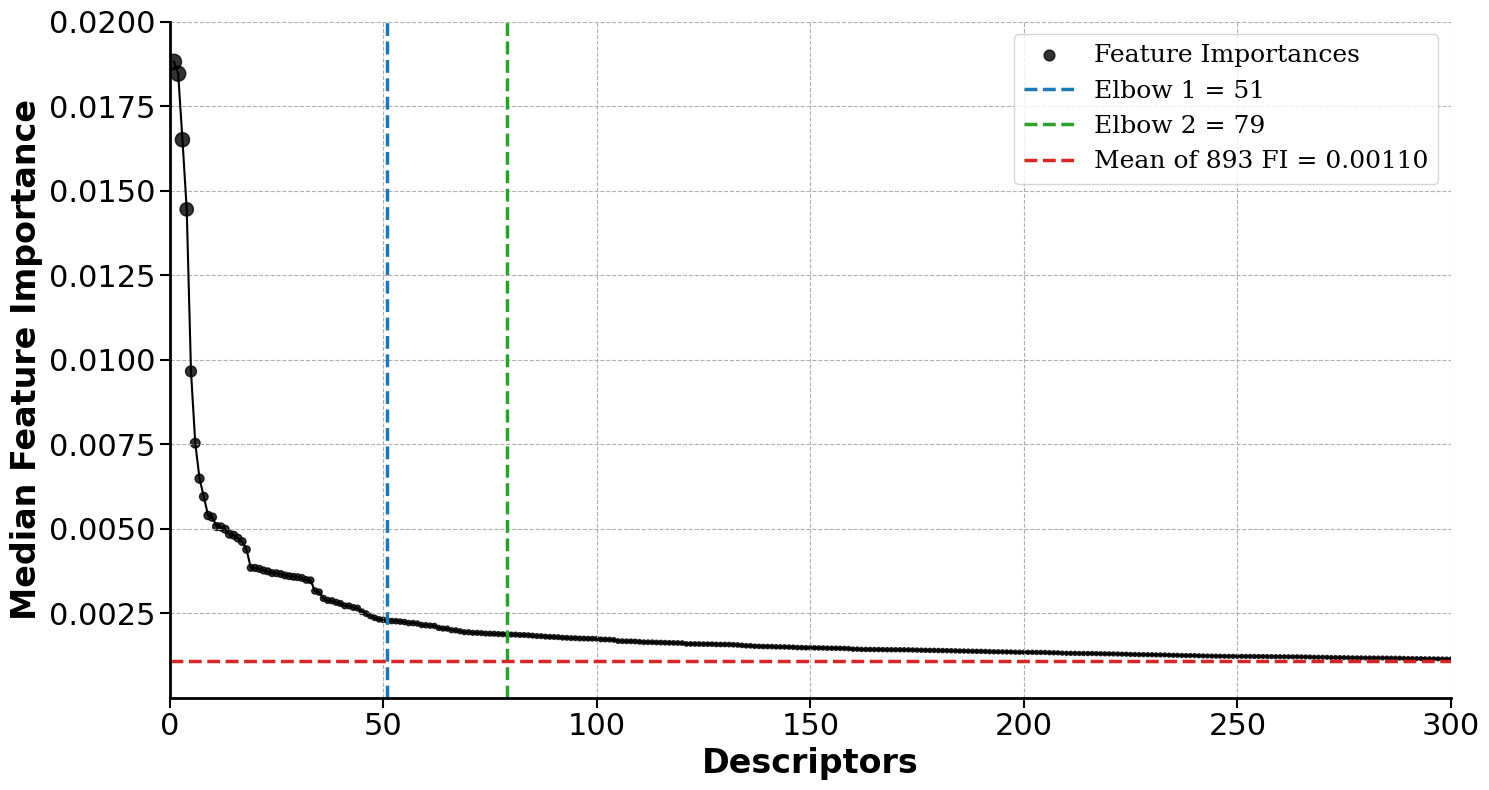

In [5]:
### Visualization: Feature Importance Curve with Elbow Points ###

# Scale marker sizes based on normalized importance values
scaled_marker_size = (median_importances_sorted / median_importances_sorted.max()) * 120

plt.figure(figsize=(15, 8))

# Plot the line graph of sorted median importances
plt.plot(feature_indices, median_importances_sorted, color='black', linewidth=1.5)

# Set font to Times New Roman
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# Scatter points with variable marker sizes
plt.scatter(
    feature_indices,
    median_importances_sorted,
    s=scaled_marker_size,
    color='black',
    alpha=0.8,
    label='Feature Importances'
)

# Plot vertical line at first elbow
if elbow_1 is not None:
    plt.axvline(
        x=elbow_1,
        color='tab:blue',
        linestyle='--',
        lw=2.5,
        label=f'Elbow 1 = {elbow_1}'
    )

# Plot vertical line at second elbow
if elbow_2 is not None:
    plt.axvline(
        x=elbow_2,
        color='tab:green',
        linestyle='--',
        lw=2.5,
        label=f'Elbow 2 = {elbow_2}'
    )

# Plot horizontal line for the global mean
plt.axhline(
    y=mean_893_importance,
    color='tab:red',
    linestyle='--',
    lw=2.5,
    label=f'Mean of 893 FI = {mean_893_importance:.5f}'
)

# Axis labels and limits
plt.xlabel('Descriptors', fontsize=24, fontweight='bold')
plt.ylabel('Median Feature Importance', fontsize=24, fontweight='bold')
plt.xlim(0, 300)
plt.ylim(0, 0.02)
plt.yticks([tick for tick in plt.yticks()[0] if tick != 0])
plt.tick_params(axis='both', labelsize=22, width=1.5, length=7)

# Clean up plot borders
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.grid(True, linestyle='--', linewidth=0.8)
plt.legend(fontsize=18, loc='best')

# Save the figure at high resolution
plt.tight_layout()
#plt.savefig('Feature Importances with Elbow Point.jpg', dpi=300)
plt.show()

### **Save the Top51 descriptors to .txt**

In [7]:
# Select top 51 features based on elbow point analysis
top_51_features = median_importances_sorted.index[:51]

In [10]:
# Save selected descriptor names (Top 51)
with open("top_51_features.txt", "w", encoding="utf-8") as f:
    for feat in top_51_features:
        f.write(feat + "\n")